In [4190]:

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime as dt

import folium
import random

from sksurv.nonparametric import kaplan_meier_estimator

from sklearn.experimental import enable_iterative_imputer


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, auc, precision_recall_curve

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier

from optbinning import BinningProcess
from optbinning import Scorecard

os.getcwd()


'/Users/chiomanwuzi/jupyter_env'

In [4124]:
# import shipment data

ship_data = pd.read_csv(str(os.getcwd()) + "/take_home_dataset.csv")
ship_data.head(10)

# round the latitudes and longitudes to the same specificity - 3 decimal points

transform_columns = ["origin_lat", "origin_long", "destination_lat", "destination_long"]
ship_data[transform_columns] = ship_data[transform_columns].round(3)
ship_data = ship_data.sort_values(by = ["shipment_id", "device_time"], ascending = True)


In [4125]:
display(ship_data)

,shipment_id,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,origin_lat,origin_long,destination_lat,destination_long,leg_name
0,controlant-142807,2022-12-06 12:43:20+00:00,47.7170000000,8.6560000000,18.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Schaffhausen
1,controlant-142807,2022-12-06 13:31:39+00:00,47.5860000000,8.6860000000,8.4000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Schaffhausen to Zurich
2,controlant-142807,2022-12-06 14:31:39+00:00,47.4540000000,8.5720000000,6.1000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Zurich
3,controlant-142807,2022-12-06 15:31:38+00:00,47.4540000000,8.5710000000,5.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Zurich
4,controlant-142807,2022-12-06 16:31:39+00:00,47.4620000000,8.5760000000,5.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Zurich
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3883,"controlant-82987898,82987899",2023-03-10 09:25:36+00:00,41.1100000000,-87.2720000000,4.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Chicago to Shepherdsville
3884,"controlant-82987898,82987899",2023-03-10 10:24:23+00:00,40.2670000000,-86.6750000000,4.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Chicago to Shepherdsville
3885,"controlant-82987898,82987899",2023-03-10 11:24:19+00:00,39.5180000000,-86.0240000000,4.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Chicago to Shepherdsville
3886,"controlant-82987898,82987899",2023-03-10 12:24:18+00:00,38.5460000000,-85.7670000000,4.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,38.0050000000,-85.7070000000,Chicago to Shepherdsville


In [4126]:
# understand the variable types and check for missing variables

ship_data.info()
ship_data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3888 entries, 0 to 3887
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   shipment_id       3888 non-null   object 
 1   device_time       3888 non-null   object 
 2   latitude          3888 non-null   float64
 3   longitude         3888 non-null   float64
 4   temperature       3888 non-null   float64
 5   lower_threshold   3888 non-null   int64  
 6   upper_threshold   3888 non-null   int64  
 7   origin            3888 non-null   object 
 8   destination       3888 non-null   object 
 9   origin_lat        3888 non-null   float64
 10  origin_long       3888 non-null   float64
 11  destination_lat   3888 non-null   float64
 12  destination_long  3888 non-null   float64
 13  leg_name          3888 non-null   object 
dtypes: float64(7), int64(2), object(5)
memory usage: 425.4+ KB


shipment_id         0
device_time         0
latitude            0
longitude           0
temperature         0
lower_threshold     0
upper_threshold     0
origin              0
destination         0
origin_lat          0
origin_long         0
destination_lat     0
destination_long    0
leg_name            0
dtype: int64

In [4127]:
# understand how many checkpoints are avaiable for each shipment

checkpoints = pd.DataFrame(ship_data.groupby(['shipment_id'])['shipment_id'].count().sort_values())
checkpoints = checkpoints.rename(columns = {"shipment_id":"num_of_checkpoints"})
checkpoints
#the range of the number of checkpoints for each shipment is between 39 and 164
ship_data = pd.merge(ship_data, checkpoints, left_on = "shipment_id", right_index = True)


In [4128]:
# map the routes for the shipments
# define the boundaries of the map

min_lat = ship_data['latitude'].min()
max_lat = ship_data['latitude'].max()
min_lon = ship_data['longitude'].min()
max_lon = ship_data['longitude'].max()

shipments_map = folium.Map(
    max_bounds=True,
    location=[-20, -40],
    zoom_start=3,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon,
    tiles="openstreetmap"
)


In [4129]:
# perform preliminary variable transformations


ship_data['lat_long'] = list(zip(ship_data['latitude'], ship_data['longitude']))
ship_data['device_time'] = pd.to_datetime(ship_data['device_time'])
ship_data["longitude"] = np.where(ship_data["longitude"] == -85.708, -85.707, ship_data["longitude"])


In [4130]:
# in order to plot the markers and the routes for the shipments, group all of the points and create a line connecting them

grouped_points = pd.DataFrame(ship_data.groupby(['shipment_id'])['lat_long'].agg(list))
grouped_points.head(5)



,lat_long
shipment_id,
controlant-142807,"[(47.717, 8.656), (47.586, 8.686), (47.454, 8...."
controlant-142824,"[(47.717, 8.656), (47.606, 8.688), (47.454, 8...."
controlant-142845,"[(47.717, 8.656), (47.717, 8.656), (47.745, 8...."
controlant-142848,"[(47.717, 8.656), (47.717, 8.656), (47.743, 8...."
controlant-142922,"[(47.717, 8.656), (47.677, 8.63), (47.58, 8.68..."


In [4131]:
# plot markers for the begnning end, and the complete route for all the shipments
# visuallize if there are outlier shipment locations along the routes.


folium.Marker((47.717, 8.656), ).add_to(shipments_map)
# plot the end of the route
for route in grouped_points.iloc():
    #print(len(route['lat_long']))
    #print(route['lat_long'][len(route['lat_long'])-1])
    folium.Marker(route['lat_long'][len(route['lat_long'])-1], color = "red").add_to(shipments_map)
    folium.Marker(route['lat_long'][round(len(route['lat_long'])/2)], color = "red").add_to(shipments_map)
# for route in grouped_points.iloc():
#     #print(route['lat_long'])
    colors = ["red", "orange", "yellow", "green", "blue", "purple", "black", "pink"]
    folium.PolyLine(route['lat_long'], color= random.choice(colors), tooltip = "Coast").add_to(shipments_map)

shipments_map


In [4132]:
# perform further variable transformations
# create a variable for whether the checkpoint is the origin point and destination point.

ship_data["origin_lat_long"] = list(zip(ship_data['origin_lat'], ship_data['origin_long']))
ship_data["destination_lat_long"] = list(zip(ship_data['destination_lat'], ship_data['destination_long']))

ship_data["origin_bool"] = np.where(ship_data['lat_long'] == ship_data['origin_lat_long'],True,False)



In [4133]:
# spot check if the final latitude and longitude coordinations of each shipment is the same as the destination
# understand if all the shipments make it to the destination or if loss of shipment/ did not make it to the destination
# is also a signal for risk

ship_data[['shipment_id','device_time', 'lat_long', 'destination_lat_long']].groupby(["shipment_id"]).last()


,device_time,lat_long,destination_lat_long
shipment_id,,,
controlant-142807,2022-12-08 15:31:40+00:00,"(37.996, -85.699)","(38.005, -85.707)"
controlant-142824,2022-12-09 13:24:03+00:00,"(38.006, -85.735)","(38.005, -85.707)"
controlant-142845,2022-12-13 13:52:16+00:00,"(38.005, -85.708)","(38.005, -85.707)"
controlant-142848,2022-12-13 13:33:25+00:00,"(37.991, -85.731)","(38.005, -85.707)"
controlant-142922,2022-12-15 15:58:40+00:00,"(38.005, -85.708)","(38.005, -85.707)"
controlant-142924,2022-12-14 15:53:10+00:00,"(38.006, -85.735)","(38.005, -85.707)"
controlant-142928,2022-12-21 13:35:01+00:00,"(37.996, -85.699)","(38.005, -85.707)"
controlant-142949,2022-12-20 12:51:19+00:00,"(37.996, -85.699)","(38.005, -85.707)"
controlant-142950,2022-12-20 12:55:11+00:00,"(38.006, -85.733)","(38.005, -85.707)"


In [4134]:
# create a distance variable between the origin and the destination using the haversine distance

# define the variable for the haversine distance
def route_distance(data, starting_lat, starting_long, ending_lat, ending_long):
    for row in data.iterrows():
        lat_distance = np.radians(data[starting_lat] - data[starting_long])
        long_distance = np.radians(data[ending_lat] - data[ending_long])
        distance_a = (np.sin(lat_distance/2) * np.sin(lat_distance/2) +
        np.cos(np.radians(data[starting_lat])) * np.cos(np.radians(data[ending_lat])) *
        np.sin(data[starting_long]) * np.sin(data[ending_long]))
        distance_b = 2 * np.arctan2(np.sqrt(distance_a), np.sqrt(1- distance_a))
        distance_c = 6371 * distance_b
        return distance_c

# create variables for the distance between the orgin and the destination of each shipment
ship_data['total_route_length'] = route_distance(ship_data, 'origin_lat', 'origin_long','destination_lat', 'destination_long')
ship_data['distance_from_origin'] = route_distance(ship_data, 'origin_lat', 'origin_long', 'latitude','longitude')
ship_data['distance_to_destination'] = route_distance(ship_data, 'latitude','longitude', 'destination_lat', 'destination_long')


In [4135]:
# create boolean variable for whether the shipment is within the temperature range at the checkpoint

ship_data["within_temp_bounds"] = np.where((ship_data['temperature'] >= ship_data['lower_threshold']) & (ship_data['temperature'] <= ship_data['upper_threshold']),True,False)


In [4136]:
# create variables around the temperature differences between the lower bound and the upper bound and the average temperatures across all checkpoints

ship_data["temp_from_lower_bound"] =  abs(ship_data['lower_threshold'] - ship_data['temperature'])
ship_data["temp_from_upper_bound"] = abs(ship_data['upper_threshold'] - ship_data['temperature']) 

# these variables will be redundant at the shipment level and are deduplicated during modeling and analysis
temp_avgs = pd.merge(ship_data.groupby(['shipment_id'])["temp_from_lower_bound"].mean(), ship_data.groupby(['shipment_id'])["temp_from_upper_bound"].mean(), left_index = True, right_index = True)
temp_avgs = temp_avgs.rename(columns = {"temp_from_lower_bound": "avg_temp_from_lower_bound", "temp_from_upper_bound":"avg_temp_from_upper_bound"})


In [4137]:
# merge the original dataset with the newly created group vaeriables

ship_data = pd.merge(ship_data, temp_avgs,left_on = "shipment_id", right_index = True )


In [4138]:
# create a variable for the number of times shipment falls out of the bounds of the temperature

temp_percent = pd.DataFrame(ship_data.groupby(['shipment_id'])['within_temp_bounds'].sum() / ship_data.groupby(['shipment_id'])['shipment_id'].count() * 100)
temp_percent = temp_percent.rename(columns = {0:'percent_non_risky'})
ship_data = pd.merge(ship_data, temp_percent, on = "shipment_id")


In [4139]:
#create variable for the length of time the entire route took

departure_time = pd.DataFrame(ship_data.groupby(['shipment_id']).first()['device_time'])
arrival_time = pd.DataFrame(ship_data.groupby(['shipment_id']).last()['device_time'])


In [4140]:
# create variables for the time from origin to destination in days and in minutes

travel_df = pd.merge(departure_time, arrival_time, on = "shipment_id")
travel_df['device_time_y'] = pd.to_datetime(travel_df['device_time_y'])
travel_df['device_time_x'] = pd.to_datetime(travel_df['device_time_x'])

travel_df.rename(columns = {"device_time_x": "origin_time", "device_time_y":"destination_time"}, inplace = True)

travel_df['origin_to_destination_time'] = (travel_df['destination_time'] - travel_df['origin_time'])

travel_df['mins_to_destination_from_origin'] = (travel_df['origin_to_destination_time'].dt.seconds)/60
travel_df['origin_to_destination_time'] = travel_df['origin_to_destination_time'].dt.days




In [4141]:
# merge all the new variables into the full dataframe
temp_df = pd.merge(ship_data, travel_df, left_on = "shipment_id", right_index = True)
temp_df['mins_since_prev_checkpoint'] = temp_df.groupby(['shipment_id'])['device_time'].diff().dt.seconds/60
temp_df = temp_df.set_index('shipment_id')
temp_df.head()

,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,origin_lat,origin_long,...,temp_from_lower_bound,temp_from_upper_bound,avg_temp_from_lower_bound,avg_temp_from_upper_bound,percent_non_risky,origin_time,destination_time,origin_to_destination_time,mins_to_destination_from_origin,mins_since_prev_checkpoint
shipment_id,,,,,,,,,,,,,,,,,,,,,
controlant-142807,2022-12-06 12:43:20+00:00,47.7170000000,8.6560000000,18.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,16.8000000000,10.8000000000,3.8813953488,2.6395348837,95.3488372093,2022-12-06 12:43:20+00:00,2022-12-08 15:31:40+00:00,2,168.3333333333,NaN
controlant-142807,2022-12-06 13:31:39+00:00,47.5860000000,8.6860000000,8.4000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,6.4000000000,0.4000000000,3.8813953488,2.6395348837,95.3488372093,2022-12-06 12:43:20+00:00,2022-12-08 15:31:40+00:00,2,168.3333333333,48.3166666667
controlant-142807,2022-12-06 14:31:39+00:00,47.4540000000,8.5720000000,6.1000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,4.1000000000,1.9000000000,3.8813953488,2.6395348837,95.3488372093,2022-12-06 12:43:20+00:00,2022-12-08 15:31:40+00:00,2,168.3333333333,60.0000000000
controlant-142807,2022-12-06 15:31:38+00:00,47.4540000000,8.5710000000,5.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,3.5000000000,2.5000000000,3.8813953488,2.6395348837,95.3488372093,2022-12-06 12:43:20+00:00,2022-12-08 15:31:40+00:00,2,168.3333333333,59.9833333333
controlant-142807,2022-12-06 16:31:39+00:00,47.4620000000,8.5760000000,5.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,3.6000000000,2.4000000000,3.8813953488,2.6395348837,95.3488372093,2022-12-06 12:43:20+00:00,2022-12-08 15:31:40+00:00,2,168.3333333333,60.0166666667


In [4142]:
# create variables for the timestamp, latitiude, and longitude of the first and last shipment to perform distance and 
# time difference metrics at the time of the checkpoint with the origin and destination timestamps and locations

# a checkpoint is defined in this regard as a time where the location, time, and temperature that are recorded outside
# of the orgin point and the destination point

temp_df = pd.merge(temp_df, pd.to_datetime(temp_df.groupby(['shipment_id'])['device_time'].nth(1)), left_index = True, right_index = True)
temp_df = temp_df.rename(columns = {'device_time_y': "first_checkpoint_time"})

temp_df = pd.merge(temp_df, pd.to_datetime(temp_df.groupby(['shipment_id'])['device_time_x'].nth(-2)), left_index = True, right_index = True)
temp_df = temp_df.rename(columns = {'device_time_x_y': "last_checkpoint_time"})

temp_df = temp_df.rename(columns = {'device_time_x_x': "device_time"})

temp_df = pd.merge(temp_df, temp_df.groupby(['shipment_id'])['latitude'].nth(1), left_index = True, right_index = True)
temp_df = temp_df.rename(columns = {'latitude_y': "first_checkpoint_lat"})

temp_df = pd.merge(temp_df, temp_df.groupby(['shipment_id'])['longitude'].nth(1), left_index = True, right_index = True)
temp_df = temp_df.rename(columns = {'longitude_y': "first_checkpoint_long"})


temp_df = pd.merge(temp_df, temp_df.groupby(['shipment_id'])['latitude_x'].nth(-2), left_index = True, right_index = True)
temp_df = temp_df.rename(columns = {'latitude_x_y': "last_checkpoint_lat"})

temp_df = pd.merge(temp_df, temp_df.groupby(['shipment_id'])['longitude_x'].nth(-2), left_index = True, right_index = True)
temp_df = temp_df.rename(columns = {'longitude_x_y': "last_checkpoint_long"})

temp_df = temp_df.rename(columns = {'latitude_x_x': 'latitude', 'longitude_x_x':'longitude'})



In [4143]:
full_df = temp_df.copy()

In [4144]:
# more variable transformations with time differenes in time and distances

full_df['mins_to_first_checkpoint'] = full_df['first_checkpoint_time'] - full_df['origin_time']
full_df['mins_to_first_checkpoint'] = full_df['mins_to_first_checkpoint'].dt.seconds/60

full_df['mins_from_last_checkpoint'] = full_df['destination_time'] - full_df['last_checkpoint_time']
full_df['mins_from_last_checkpoint'] = full_df['mins_from_last_checkpoint'].dt.seconds/60

full_df['distance_to_first_checkpoint'] = route_distance(full_df, 'origin_lat', 'origin_long','first_checkpoint_lat', 'first_checkpoint_long')
full_df['distance_from_last_checkpoint'] = route_distance(full_df,'destination_lat', 'destination_long', 'last_checkpoint_lat', 'last_checkpoint_long')


In [4145]:
# min, max, and average temperature variables at the shipment level


temp_metrics = pd.DataFrame(full_df.groupby(['shipment_id'])['temperature'].max())
temp_metrics = pd.merge(temp_metrics, full_df.groupby(['shipment_id'])['temperature'].min(), left_index = True, right_index = True)
temp_metrics = pd.merge(temp_metrics, full_df.groupby(['shipment_id'])['temperature'].mean(), left_index = True, right_index = True)
temp_metrics = temp_metrics.rename(columns = {"temperature_x":"max_shipment_temperature", "temperature_y":"min_shipment_temperature", "temperature":"avg_route_temperature"})
full_df = pd.merge(full_df, temp_metrics, on = "shipment_id")

In [4146]:
full_df.head(20)

,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,origin_lat,origin_long,...,first_checkpoint_long,last_checkpoint_lat,last_checkpoint_long,mins_to_first_checkpoint,mins_from_last_checkpoint,distance_to_first_checkpoint,distance_from_last_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature
shipment_id,,,,,,,,,,,,,,,,,,,,,
controlant-142807,2022-12-06 12:43:20+00:00,47.7170000000,8.6560000000,18.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 13:31:39+00:00,47.5860000000,8.6860000000,8.4000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 14:31:39+00:00,47.4540000000,8.5720000000,6.1000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 15:31:38+00:00,47.4540000000,8.5710000000,5.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 16:31:39+00:00,47.4620000000,8.5760000000,5.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 17:31:39+00:00,47.4520000000,8.5650000000,5.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 18:31:40+00:00,47.5400000000,8.6810000000,5.3000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 19:32:35+00:00,47.9170000000,8.6600000000,5.2000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488
controlant-142807,2022-12-06 20:32:00+00:00,48.5760000000,8.8620000000,5.3000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,8.6860000000,38.6750000000,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488


In [4147]:
# plot the points where the temperature of shipments is out of range - at risk points
# understand if there is a specific origin, checkpoint that is correlated with at_risk temperatures.

min_lat_risk = full_df.loc[full_df['within_temp_bounds'] == False, 'latitude'].min()
max_lat_risk = full_df.loc[full_df['within_temp_bounds'] == False, 'latitude'].max()
min_lon_risk = full_df.loc[full_df['within_temp_bounds'] == False, 'longitude'].min()
max_lon_risk = full_df.loc[full_df['within_temp_bounds'] == False, 'longitude'].max()


risk_map = folium.Map(
    max_bounds=True,
    location=[-20, -40],
    zoom_start=11,
    min_lat=min_lat_risk,
    max_lat=max_lat_risk,
    min_lon=min_lon_risk,
    max_lon=max_lon_risk,
    tiles="openstreetmap"
)

for risk_point in full_df[full_df['within_temp_bounds'] == False].iloc():
    folium.Marker(risk_point['lat_long'],icon = folium.Icon(color='red')).add_to(risk_map)
    folium.Marker(risk_point['origin_lat_long'],icon = folium.Icon(color='blue')).add_to(risk_map)
    folium.PolyLine(locations = (risk_point['origin_lat_long'],risk_point['lat_long']) , color= "blue", tooltip = "Coast").add_to(risk_map)

risk_map

In [4148]:
# destination_integrity_check - there is a marginal difference in coordinations of the destination location and the location
# of the final destinations by shipment, this map plots the final destination of the shipment with a 5000 meter (5km) range
# to visualize the distance from the designated destination and the actual last destination point


destination_map = folium.Map(
    #max_bounds=True,
    location=[38.005,-85.707],
    zoom_start=12,
    min_lat=min_lat_risk,
    max_lat=max_lat_risk,
    min_lon=min_lon_risk,
    max_lon=max_lon_risk,
    tiles="openstreetmap"
)

folium.Circle(location = [38.005,-85.707], radius = 5000, color = "red", fill = True).add_to(destination_map)

for destination_point in full_df.groupby("shipment_id").last().iloc():
    folium.Marker(destination_point['lat_long'],icon = folium.Icon(color='blue')).add_to(destination_map)

destination_map


In [4149]:
# variables for the minutes from the origin to each of the checkpoints

full_df['mins_to_destination_from_checkpoint'] = ((full_df['destination_time'] - full_df['device_time']).dt.seconds)/60
full_df['mins_from_origin'] = ((full_df['device_time'] - full_df['origin_time']).dt.seconds)/60
full_df


,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,origin_lat,origin_long,...,last_checkpoint_long,mins_to_first_checkpoint,mins_from_last_checkpoint,distance_to_first_checkpoint,distance_from_last_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature,mins_to_destination_from_checkpoint,mins_from_origin
shipment_id,,,,,,,,,,,,,,,,,,,,,
controlant-142807,2022-12-06 12:43:20+00:00,47.7170000000,8.6560000000,18.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488,168.3333333333,0.0000000000
controlant-142807,2022-12-06 13:31:39+00:00,47.5860000000,8.6860000000,8.4000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488,120.0166666667,48.3166666667
controlant-142807,2022-12-06 14:31:39+00:00,47.4540000000,8.5720000000,6.1000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488,60.0166666667,108.3166666667
controlant-142807,2022-12-06 15:31:38+00:00,47.4540000000,8.5710000000,5.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488,0.0333333333,168.3000000000
controlant-142807,2022-12-06 16:31:39+00:00,47.4620000000,8.5760000000,5.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488,1380.0166666667,228.3166666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"controlant-82987898,82987899",2023-03-10 09:25:36+00:00,41.1100000000,-87.2720000000,4.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7670000000,25.6333333333,52.9333333333,7804.9991825735,NaN,9.4000000000,4.3000000000,4.9539325843,231.6333333333,1166.9666666667
"controlant-82987898,82987899",2023-03-10 10:24:23+00:00,40.2670000000,-86.6750000000,4.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7670000000,25.6333333333,52.9333333333,7804.9991825735,NaN,9.4000000000,4.3000000000,4.9539325843,172.8500000000,1225.7500000000
"controlant-82987898,82987899",2023-03-10 11:24:19+00:00,39.5180000000,-86.0240000000,4.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7670000000,25.6333333333,52.9333333333,7804.9991825735,NaN,9.4000000000,4.3000000000,4.9539325843,112.9166666667,1285.6833333333


In [4150]:
# the majority of the shipments that are categorized as risky, started off their journey from the origin at temperatures above the upper threshold 

risky_temp = full_df[full_df['percent_non_risky'] < 100]
risky_temp.groupby(['shipment_id']).first()


,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,origin_lat,origin_long,...,last_checkpoint_long,mins_to_first_checkpoint,mins_from_last_checkpoint,distance_to_first_checkpoint,distance_from_last_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature,mins_to_destination_from_checkpoint,mins_from_origin
shipment_id,,,,,,,,,,,,,,,,,,,,,
controlant-142807,2022-12-06 12:43:20+00:00,47.7170000000,8.6560000000,18.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7770000000,48.3166666667,58.8000000000,7718.7702879723,NaN,18.8000000000,5.0000000000,5.8813953488,168.3333333333,0.0000000000
controlant-142824,2022-12-07 13:47:15+00:00,47.7170000000,8.6560000000,17.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7920000000,36.7333333333,58.4500000000,7711.3108727218,NaN,17.7000000000,4.8000000000,5.6974358974,1416.8000000000,0.0000000000
controlant-142845,2022-12-08 12:26:52+00:00,47.7170000000,8.6560000000,10.9000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7670000000,25.4000000000,59.4666666667,7804.9991825735,NaN,10.9000000000,5.2000000000,5.7452173913,85.4000000000,0.0000000000
controlant-142848,2022-12-08 12:36:00+00:00,47.7170000000,8.6560000000,9.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.8120000000,57.4000000000,58.0666666667,7804.9991825735,NaN,9.7000000000,5.3000000000,5.8699115044,57.4166666667,0.0000000000
controlant-142922,2022-12-13 12:27:11+00:00,47.7170000000,8.6560000000,9.0000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7410000000,28.2333333333,53.9166666667,7885.7918442115,NaN,9.0000000000,4.9000000000,5.2622222222,211.4833333333,0.0000000000
controlant-142928,2022-12-14 12:26:02+00:00,47.7170000000,8.6560000000,8.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7760000000,69.0166666667,59.9500000000,7733.5679083127,NaN,8.5000000000,4.7000000000,5.2362500000,68.9833333333,0.0000000000
"controlant-82964480, 82964481",2023-01-05 13:28:29+00:00,47.7170000000,8.6560000000,9.4000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7280000000,32.3666666667,33.7833333333,7527.1441492171,NaN,9.4000000000,5.1000000000,5.4295652174,6.2000000000,0.0000000000
"controlant-82964482, 82964483, 82964484, 82964485",2023-01-05 12:27:51+00:00,47.7170000000,8.6560000000,8.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7540000000,25.3833333333,59.9333333333,7804.9991825735,NaN,8.6000000000,5.0000000000,5.7651376147,1105.3833333333,0.0000000000
controlant-82965952,2023-01-09 12:25:39+00:00,47.7170000000,8.6560000000,15.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,8.6560000000,...,-85.7570000000,0.0000000000,31.7000000000,7804.9991825735,NaN,15.5000000000,5.0000000000,5.9800000000,211.0833333333,0.0000000000


In [4151]:
# fill the distance metrics that are produced nan from the distance or time difference transformations

full_df = full_df.fillna(0)


In [4152]:
# extract the hour of the day from the time of origin and the time of departure

full_df['departure_hour'] = full_df['origin_time'].dt.hour
full_df['arrival_hour'] = full_df['destination_time'].dt.hour


In [4183]:
# define a response variable for those that are at risk based on if the shipment fell out of the temperature threshold

full_df['no_risk'] = np.where(full_df['percent_non_risky'] < 100, True, False)
full_df = full_df.reset_index()


## Exploratory Analysis



<Axes: >

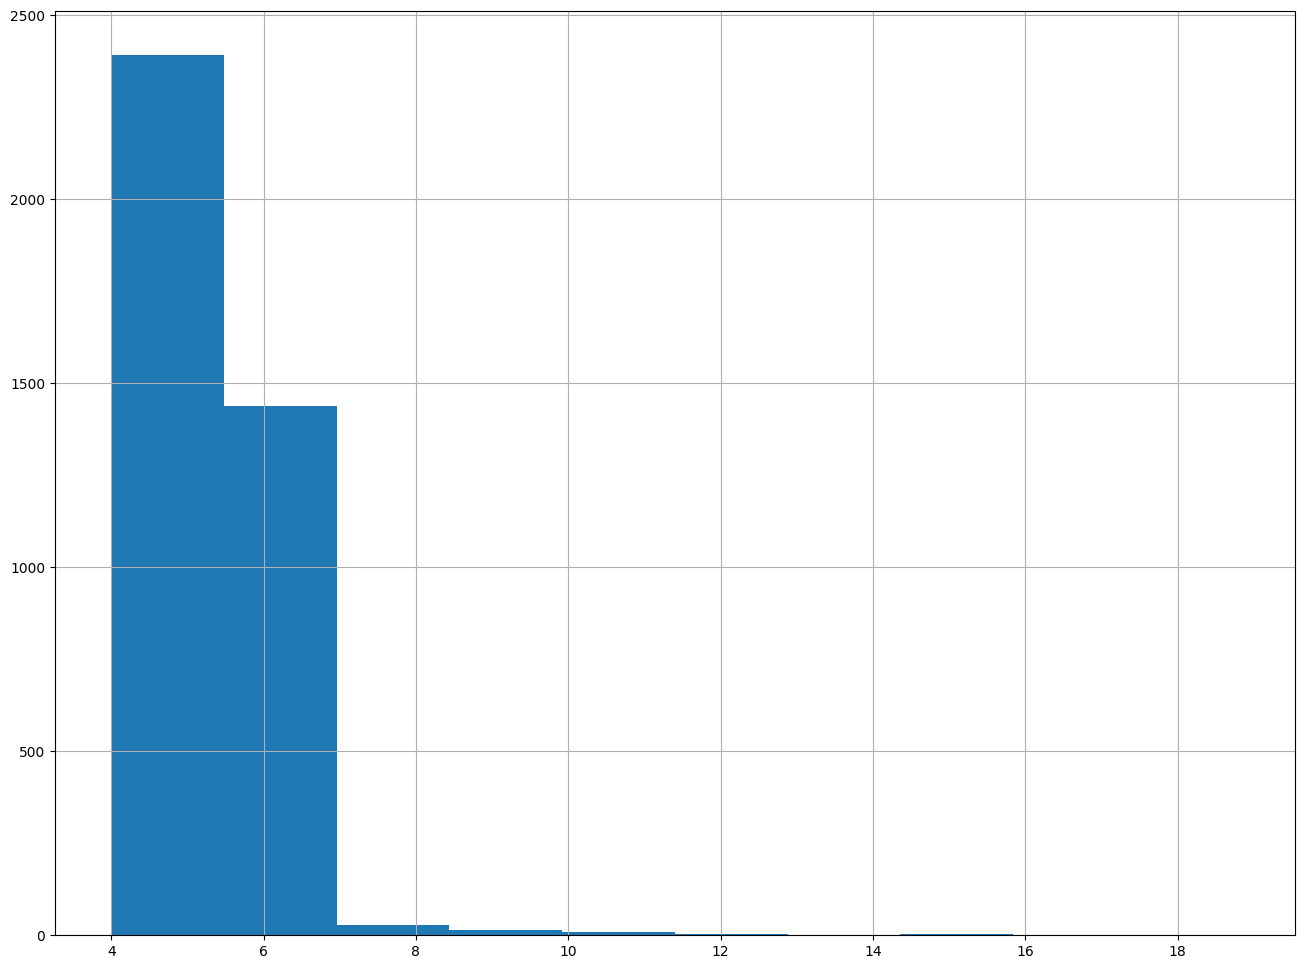

In [4154]:
# histogram of the temperature at the checkpoint level

full_df['temperature'].hist(figsize = (16,12))

<Axes: >

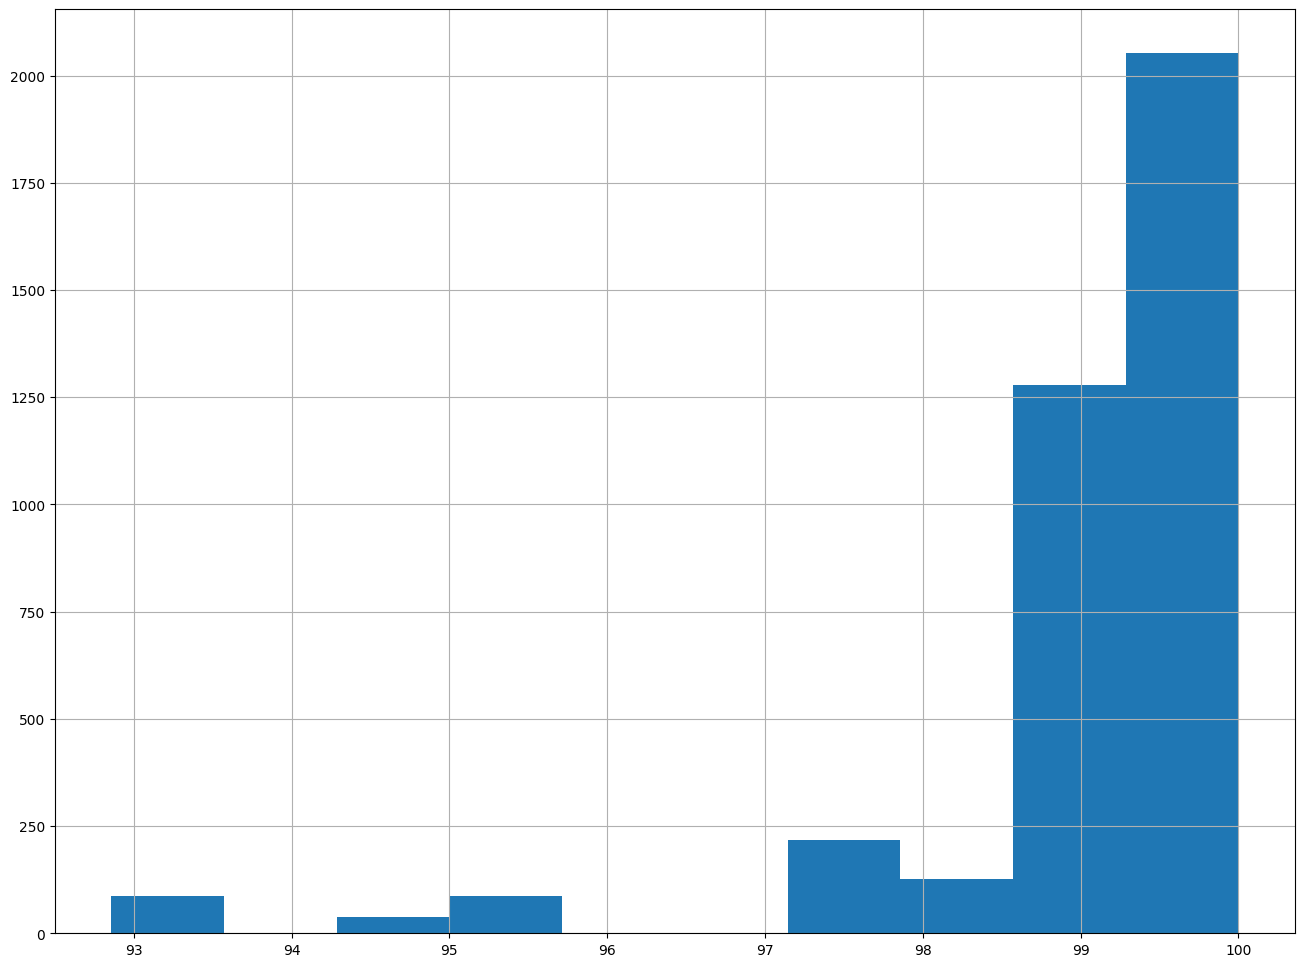

In [4155]:
# distribution of the percentage of the shipments that were not considered risky

full_df['percent_non_risky'].hist(figsize = (16,12))

<Axes: >

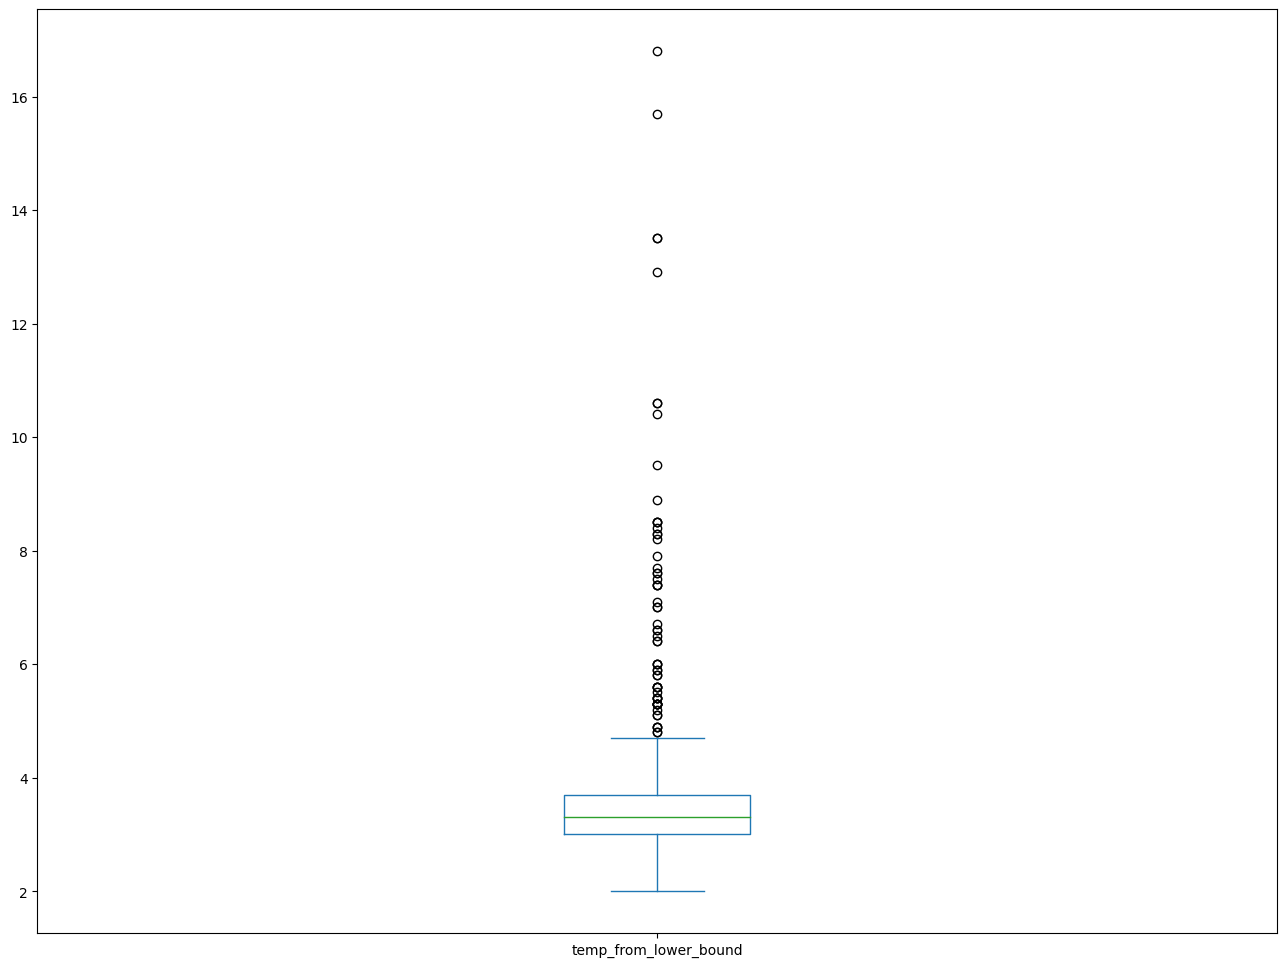

In [4156]:
# distribution of the temperature of each checkpoint of how far away from the lower bound the temperature is

full_df['temp_from_lower_bound'].plot.box(figsize = (16,12)) 

<Axes: >

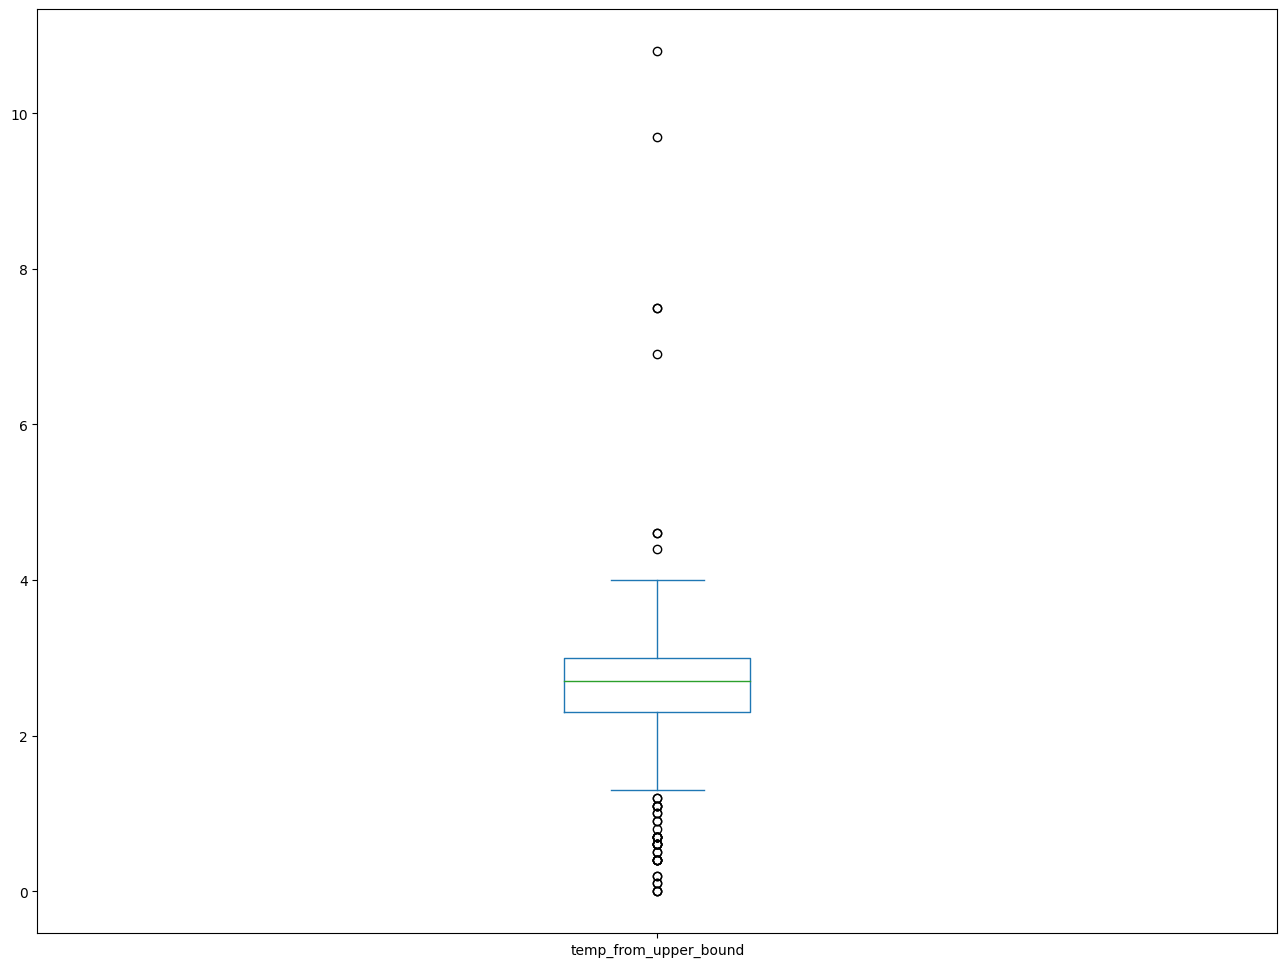

In [4157]:
# distribution of the temperature of each checkpoint of how far away from the upper bound the temperature is

full_df['temp_from_upper_bound'].plot.box(figsize = (16,12)) 

,latitude,longitude,temperature,lower_threshold,upper_threshold,origin_lat,origin_long,destination_lat,destination_long,num_of_checkpoints,...,distance_to_first_checkpoint,distance_from_last_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature,mins_to_destination_from_checkpoint,mins_from_origin,departure_hour,arrival_hour,at_risk
latitude,1.0000000000,0.9548406042,-0.0045132835,NaN,NaN,NaN,NaN,NaN,NaN,-0.0457846837,...,0.0295723682,NaN,-0.0041440767,0.0592349182,0.0236909639,0.1183644055,-0.0671276321,-0.0018597809,0.0013833287,-0.0538319171
longitude,0.9548406042,1.0000000000,0.0150787098,NaN,NaN,NaN,NaN,NaN,NaN,-0.0746350734,...,0.0140159789,NaN,-0.0084136748,0.0597410043,0.0000923383,0.0973343129,-0.1255886657,0.0286211258,-0.0136576066,-0.0561494763
temperature,-0.0045132835,0.0150787098,1.0000000000,NaN,NaN,NaN,NaN,NaN,NaN,0.0128073767,...,0.0979210953,NaN,0.2421496603,0.3994932892,0.4676327042,-0.1027869824,-0.1588776472,-0.1079727908,-0.0444603435,0.1426513559
lower_threshold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
upper_threshold,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin_lat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
origin_long,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination_lat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
destination_long,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_of_checkpoints,-0.0457846837,-0.0746350734,0.0128073767,NaN,NaN,NaN,NaN,NaN,NaN,1.0000000000,...,-0.0849053167,NaN,-0.2211877926,-0.0035780716,0.0273876839,0.0287719934,-0.0005894091,-0.1789446242,-0.2022787964,0.1236940657


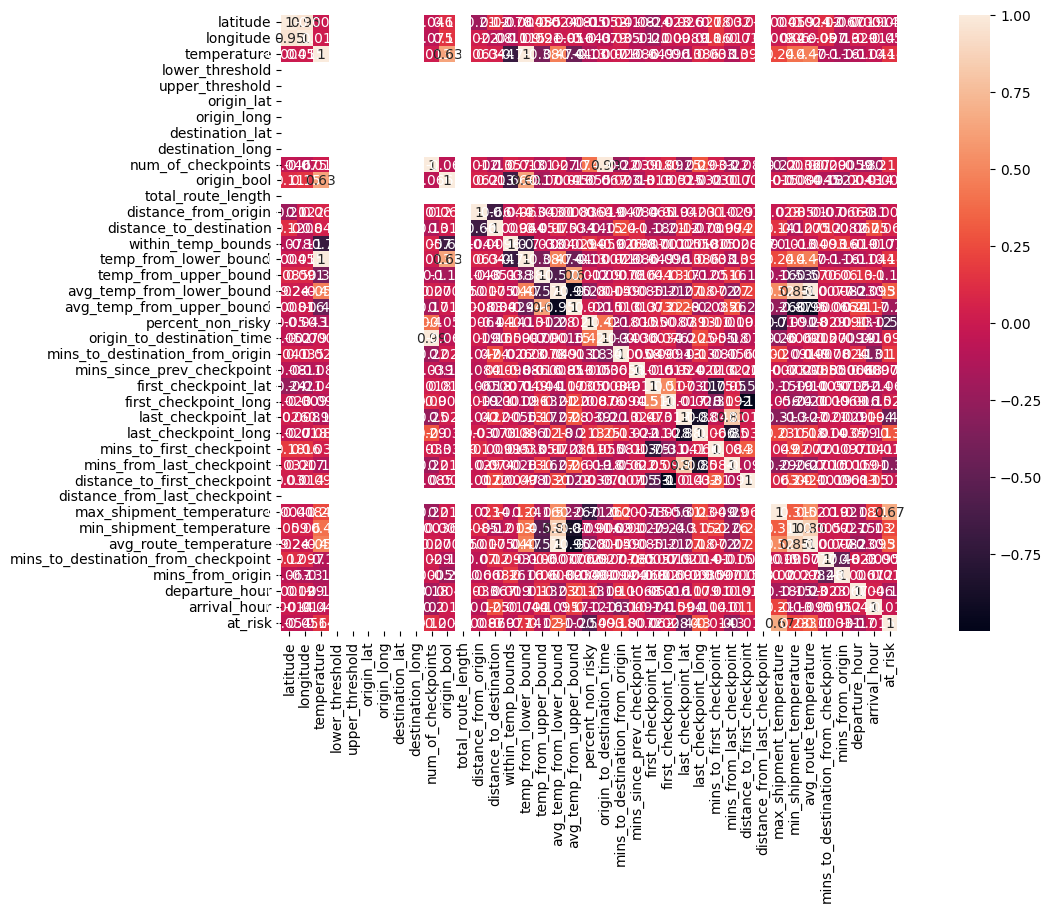

In [4158]:
# plot all of the points to understand the correlation outside of just the derived variables
# the derived variables are expected to be highly and perfectly correlated and will be reduced after further feature reduction methods

cor_plot = full_df.corr(method = 'pearson', numeric_only = True)
fig , ax = plt.subplots(figsize = (16,8))
sns.heatmap(cor_plot, square = True, annot = True)
cor_plot

array([[<Axes: title={'center': 'temp_from_lower_bound'}>,
        <Axes: title={'center': 'temp_from_upper_bound'}>,
        <Axes: title={'center': 'percent_non_risky'}>],
       [<Axes: title={'center': 'origin_time'}>,
        <Axes: title={'center': 'destination_time'}>,
        <Axes: title={'center': 'origin_to_destination_time'}>],
       [<Axes: title={'center': 'mins_to_destination_from_origin'}>,
        <Axes: title={'center': 'mins_since_prev_checkpoint'}>,
        <Axes: title={'center': 'mins_to_destination_from_checkpoint'}>],
       [<Axes: title={'center': 'mins_from_origin'}>, <Axes: >, <Axes: >]],
      dtype=object)

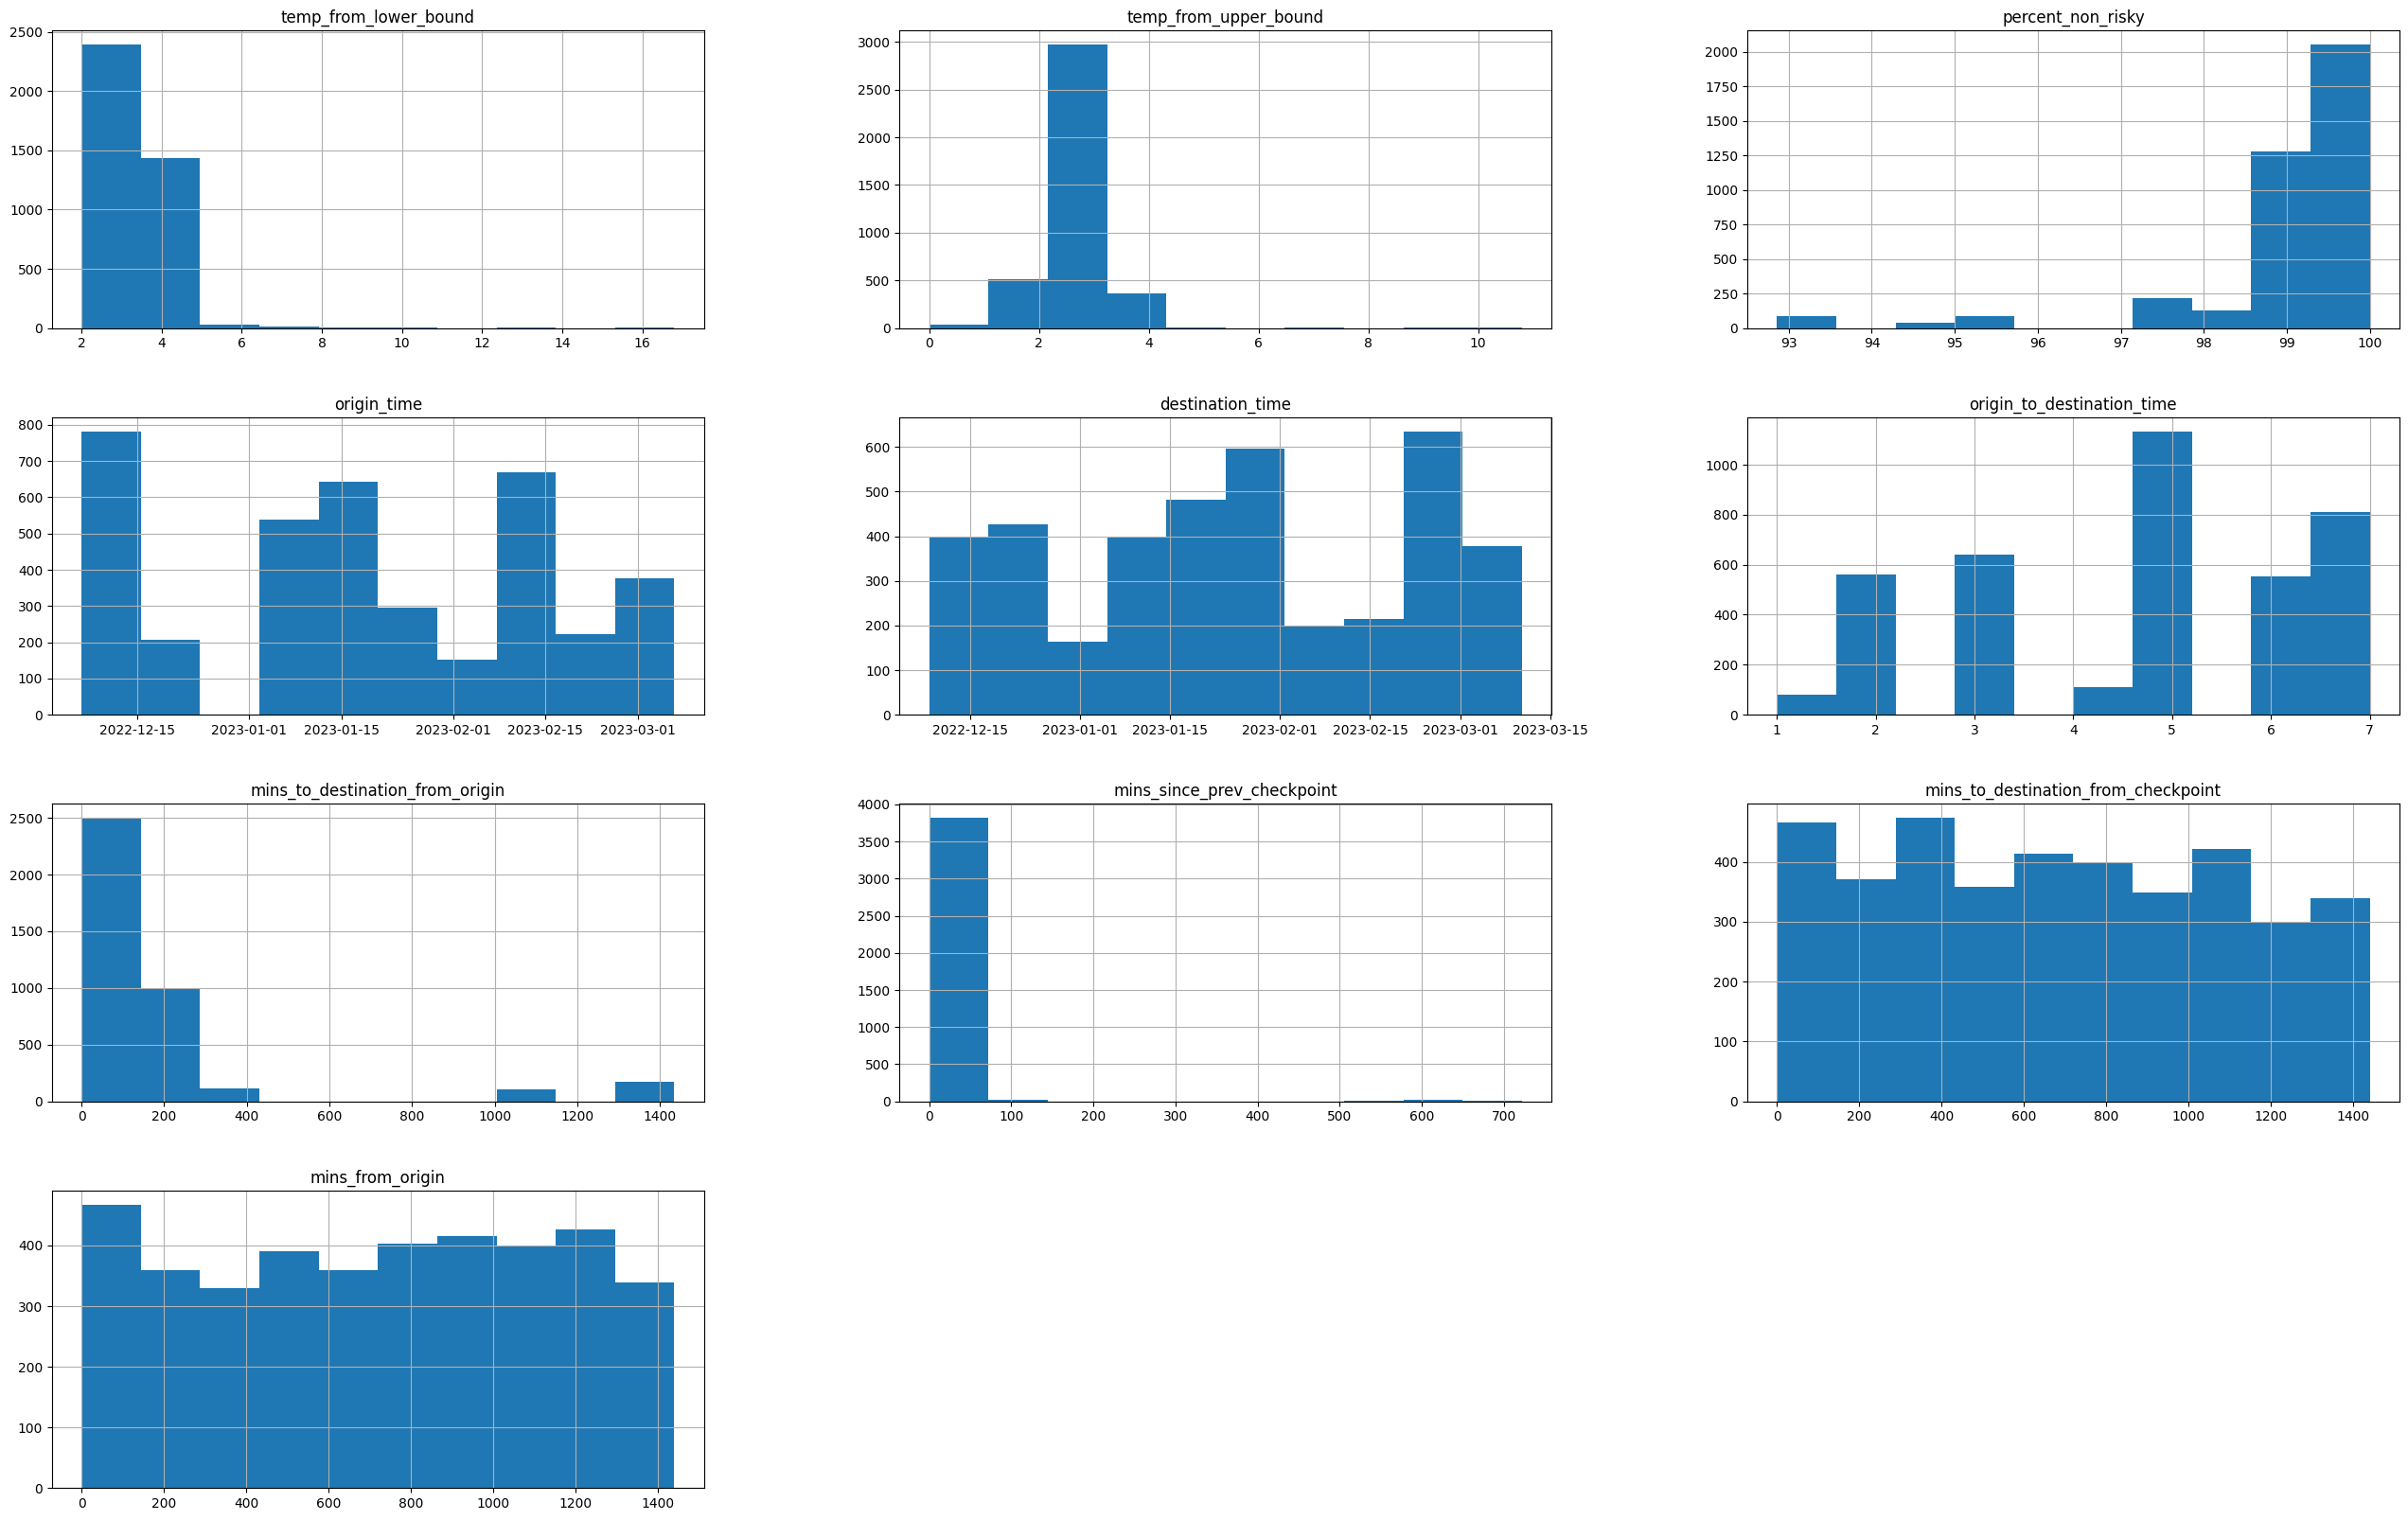

In [4159]:
#further distribution plots

full_df[['temp_from_lower_bound', 'temp_from_upper_bound', 'percent_non_risky',
       'origin_time', 'destination_time', 'origin_to_destination_time',
       'mins_to_destination_from_origin', 'mins_since_prev_checkpoint',
       'mins_to_destination_from_checkpoint', 'mins_from_origin']].hist(figsize = (32,20))

In [4160]:
# understand the percentage of checkpoints shipments that were not risky when the minutes from the origin
# to the destination fall outside of the 98th percentile

np.percentile(full_df['mins_to_destination_from_origin'], 98)
full_df.loc[full_df['mins_to_destination_from_origin'] > 1416, 'percent_non_risky']


43      94.8717948718
44      94.8717948718
45      94.8717948718
46      94.8717948718
47      94.8717948718
            ...      
3682   100.0000000000
3683   100.0000000000
3684   100.0000000000
3685   100.0000000000
3686   100.0000000000
Name: percent_non_risky, Length: 81, dtype: float64

In [4161]:
full_df.columns

Index(['shipment_id', 'device_time', 'latitude', 'longitude', 'temperature',
       'lower_threshold', 'upper_threshold', 'origin', 'destination',
       'origin_lat', 'origin_long', 'destination_lat', 'destination_long',
       'leg_name', 'num_of_checkpoints', 'lat_long', 'origin_lat_long',
       'destination_lat_long', 'origin_bool', 'total_route_length',
       'distance_from_origin', 'distance_to_destination', 'within_temp_bounds',
       'temp_from_lower_bound', 'temp_from_upper_bound',
       'avg_temp_from_lower_bound', 'avg_temp_from_upper_bound',
       'percent_non_risky', 'origin_time', 'destination_time',
       'origin_to_destination_time', 'mins_to_destination_from_origin',
       'mins_since_prev_checkpoint', 'first_checkpoint_time',
       'last_checkpoint_time', 'first_checkpoint_lat', 'first_checkpoint_long',
       'last_checkpoint_lat', 'last_checkpoint_long',
       'mins_to_first_checkpoint', 'mins_from_last_checkpoint',
       'distance_to_first_checkpoint', 'd

#### Understand the Survival Function
##### The survival function is a great way to understand longitudinal data and how the probability that a shipment is risky moves with the time variables. 

In [4162]:
# segment the dataframe by groups for the checkpoints before failure. Failure is defined as a risk incident is recorded 
# for that shipment
before_failure = (pd.DataFrame(full_df['within_temp_bounds'].eq(False)
                              .groupby(full_df['shipment_id'])
                              .apply(lambda x: ~x.cummax().shift().fillna(False))))


In [4163]:
# adjust the before failure dataset for survival analysis input

before_failure = before_failure.rename(columns = {"within_temp_bounds":"before_failure_checkpoints"})
before_failure = before_failure[before_failure['before_failure_checkpoints'] == True]
before_failure = before_failure.reset_index()
before_failure = before_failure.drop('level_1', axis = 1)
before_failure.head()
before_failure_full = pd.merge(before_failure, full_df, how = "right", left_on = 'shipment_id', right_on = "shipment_id")


In [4164]:
# segment for those shipments that did not experience a failure during the route

no_failure = full_df[full_df['percent_non_risky'] == 100]
no_failure


,shipment_id,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,origin_lat,...,distance_to_first_checkpoint,distance_from_last_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature,mins_to_destination_from_checkpoint,mins_from_origin,departure_hour,arrival_hour,at_risk
355,controlant-142924,2022-12-12 14:34:50+00:00,47.7170000000,8.6560000000,6.2000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7817.2822889988,0.0000000000,7.6000000000,4.9000000000,5.4883720930,78.3333333333,0.0000000000,14,15,False
356,controlant-142924,2022-12-12 14:53:10+00:00,47.7160000000,8.6520000000,7.6000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7817.2822889988,0.0000000000,7.6000000000,4.9000000000,5.4883720930,60.0000000000,18.3333333333,14,15,False
357,controlant-142924,2022-12-12 15:53:10+00:00,47.4620000000,8.5760000000,5.7000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7817.2822889988,0.0000000000,7.6000000000,4.9000000000,5.4883720930,0.0000000000,78.3333333333,14,15,False
358,controlant-142924,2022-12-12 16:53:09+00:00,47.4570000000,8.5700000000,5.5000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7817.2822889988,0.0000000000,7.6000000000,4.9000000000,5.4883720930,1380.0166666667,138.3166666667,14,15,False
359,controlant-142924,2022-12-12 17:53:10+00:00,47.4540000000,8.5670000000,5.2000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7817.2822889988,0.0000000000,7.6000000000,4.9000000000,5.4883720930,1320.0000000000,198.3333333333,14,15,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,"controlant-82984859,82984860",2023-03-03 10:13:20+00:00,40.7280000000,-87.0780000000,4.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,233.8166666667,1200.6000000000,14,14,False
3683,"controlant-82984859,82984860",2023-03-03 11:14:35+00:00,39.8960000000,-86.3130000000,4.8000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,172.5666666667,1261.8500000000,14,14,False
3684,"controlant-82984859,82984860",2023-03-03 12:12:45+00:00,39.1170000000,-85.9440000000,4.9000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,114.4000000000,1320.0166666667,14,14,False
3685,"controlant-82984859,82984860",2023-03-03 13:13:17+00:00,38.2260000000,-85.7460000000,4.9000000000,2,8,Schaffhausen,Shepherdsville,47.7170000000,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,53.8666666667,1380.5500000000,14,14,False


In [4165]:
# concat the before and no failure dataframes

survival_df = pd.concat([before_failure_full, no_failure])
survival_df_final = survival_df.drop_duplicates()
survival_df_final

,shipment_id,before_failure_checkpoints,device_time,latitude,longitude,temperature,lower_threshold,upper_threshold,origin,destination,...,distance_to_first_checkpoint,distance_from_last_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature,mins_to_destination_from_checkpoint,mins_from_origin,departure_hour,arrival_hour,at_risk
0,controlant-142807,True,2022-12-06 12:43:20+00:00,47.7170000000,8.6560000000,18.8000000000,2,8,Schaffhausen,Shepherdsville,...,7718.7702879723,0.0000000000,18.8000000000,5.0000000000,5.8813953488,168.3333333333,0.0000000000,12,15,True
1,controlant-142807,True,2022-12-06 13:31:39+00:00,47.5860000000,8.6860000000,8.4000000000,2,8,Schaffhausen,Shepherdsville,...,7718.7702879723,0.0000000000,18.8000000000,5.0000000000,5.8813953488,120.0166666667,48.3166666667,12,15,True
2,controlant-142807,True,2022-12-06 14:31:39+00:00,47.4540000000,8.5720000000,6.1000000000,2,8,Schaffhausen,Shepherdsville,...,7718.7702879723,0.0000000000,18.8000000000,5.0000000000,5.8813953488,60.0166666667,108.3166666667,12,15,True
3,controlant-142807,True,2022-12-06 15:31:38+00:00,47.4540000000,8.5710000000,5.5000000000,2,8,Schaffhausen,Shepherdsville,...,7718.7702879723,0.0000000000,18.8000000000,5.0000000000,5.8813953488,0.0333333333,168.3000000000,12,15,True
4,controlant-142807,True,2022-12-06 16:31:39+00:00,47.4620000000,8.5760000000,5.6000000000,2,8,Schaffhausen,Shepherdsville,...,7718.7702879723,0.0000000000,18.8000000000,5.0000000000,5.8813953488,1380.0166666667,228.3166666667,12,15,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3682,"controlant-82984859,82984860",NaN,2023-03-03 10:13:20+00:00,40.7280000000,-87.0780000000,4.8000000000,2,8,Schaffhausen,Shepherdsville,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,233.8166666667,1200.6000000000,14,14,False
3683,"controlant-82984859,82984860",NaN,2023-03-03 11:14:35+00:00,39.8960000000,-86.3130000000,4.8000000000,2,8,Schaffhausen,Shepherdsville,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,172.5666666667,1261.8500000000,14,14,False
3684,"controlant-82984859,82984860",NaN,2023-03-03 12:12:45+00:00,39.1170000000,-85.9440000000,4.9000000000,2,8,Schaffhausen,Shepherdsville,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,114.4000000000,1320.0166666667,14,14,False
3685,"controlant-82984859,82984860",NaN,2023-03-03 13:13:17+00:00,38.2260000000,-85.7460000000,4.9000000000,2,8,Schaffhausen,Shepherdsville,...,7804.9991825735,0.0000000000,7.3000000000,4.7000000000,5.2000000000,53.8666666667,1380.5500000000,14,14,False


In [4166]:
# limit the variables in thee dataframe for the survival function

survival_df_final = survival_df_final[['shipment_id','percent_non_risky','mins_from_origin', 'mins_since_prev_checkpoint', 'within_temp_bounds']]
survival_df_final.tail(5)


,shipment_id,percent_non_risky,mins_from_origin,mins_since_prev_checkpoint,within_temp_bounds
3682,"controlant-82984859,82984860",100.0000000000,1200.6000000000,60.6000000000,True
3683,"controlant-82984859,82984860",100.0000000000,1261.8500000000,61.2500000000,True
3684,"controlant-82984859,82984860",100.0000000000,1320.0166666667,58.1666666667,True
3685,"controlant-82984859,82984860",100.0000000000,1380.5500000000,60.5333333333,True
3686,"controlant-82984859,82984860",100.0000000000,1434.4166666667,53.8666666667,True



##### To calculate the survival probability for the individual shipments, S(t) = # of shipments that were not at risk (stayed within temperature bounds) / total number of shipments. This limits the estimator to those that have exact minutes of survival to those that are represented in the dataset. In order to understand for those that are not represented, the Kaplan-Meier estimator.


Text(0.5, 0, 'Time t (minutes)')

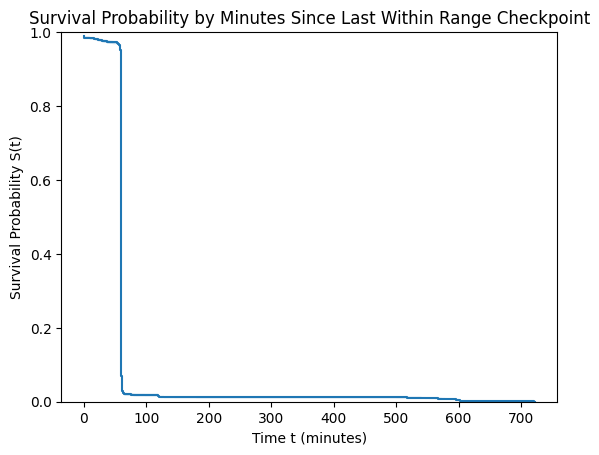

In [4167]:
# used the kaplen meier estimator to estimate the surival function as a function of the minutes since the previous checkpoint 
# either the last or the checkpoint before the first failure

time_mins, survival_probability, confidence_interval = kaplan_meier_estimator(survival_df_final['within_temp_bounds'], 
                                                                              survival_df_final['mins_since_prev_checkpoint'], 
                                                                              conf_type = "log-log")

# plot the survival function
plt.step(time_mins, survival_probability, where = "post")
plt.fill_between(time_mins, confidence_interval[0], confidence_interval[1], alpha = .25, step = "post")
plt.ylim(0,1)
plt.title("Survival Probability by Minutes Since Last Within Range Checkpoint")
plt.ylabel("Survival Probability S(t)")
plt.xlabel("Time t (minutes)")


Text(0.5, 0, 'Time t (minutes)')

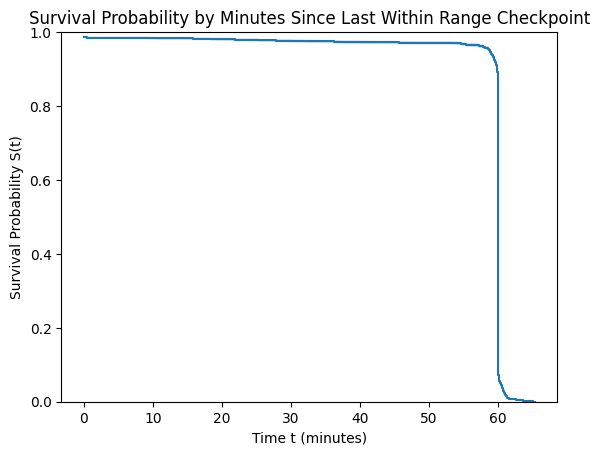

In [4168]:

# same survival plot as a cuntion of the minutes since the last checkpoint except binned at the 98th percentile

percentile_limit = np.percentile(survival_df_final['mins_since_prev_checkpoint'], 98)

time_mins, survival_probability, confidence_interval = kaplan_meier_estimator(survival_df_final.loc[survival_df_final['mins_since_prev_checkpoint'] <= percentile_limit, 'within_temp_bounds'], 
                                                                              survival_df_final.loc[survival_df_final['mins_since_prev_checkpoint'] <= percentile_limit, 'mins_since_prev_checkpoint'], 
                                                                              conf_type = "log-log")

plt.step(time_mins, survival_probability, where = "post")
plt.fill_between(time_mins, confidence_interval[0], confidence_interval[1], alpha = .25, step = "post")
plt.ylim(0,1)
plt.title("Survival Probability by Minutes Since Last Within Range Checkpoint")
plt.ylabel("Survival Probability S(t)")
plt.xlabel("Time t (minutes)")


Text(0.5, 0, 'Time t (minutes)')

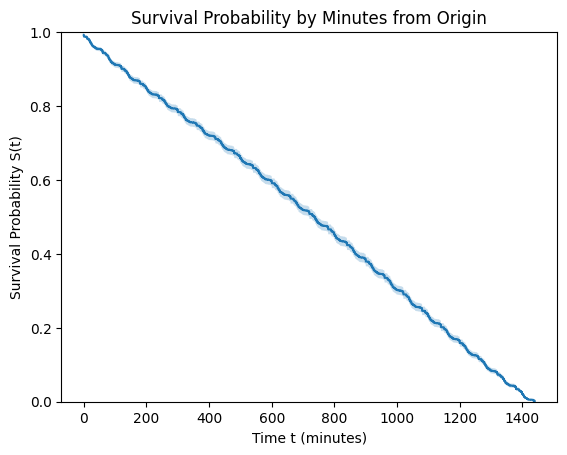

In [4169]:
# survival estimator as a function of the minutes from the origin before completion or failure

time_mins, survival_probability, confidence_interval = kaplan_meier_estimator(survival_df_final['within_temp_bounds'], 
                                                                              survival_df_final['mins_from_origin'], 
                                                                              conf_type = "log-log")

plt.step(time_mins, survival_probability, where = "post")
plt.fill_between(time_mins, confidence_interval[0], confidence_interval[1], alpha = .25, step = "post")
plt.ylim(0,1)
plt.title("Survival Probability by Minutes from Origin")
plt.ylabel("Survival Probability S(t)")
plt.xlabel("Time t (minutes)")


In [4170]:
# add the survival probability to the dataframe

survival_probs = pd.DataFrame({'time_mins':time_mins, "survival_probability":survival_probability})
survival_probs

,time_mins,survival_probability
0,0.0000000000,0.9928505958
1,0.0166666667,0.9921140597
2,0.0333333333,0.9910092557
3,0.0500000000,0.9899044516
4,0.0666666667,0.9897203176
...,...,...
2682,1439.2166666667,0.0016597132
2683,1439.2333333333,0.0009220629
2684,1439.3500000000,0.0007376503
2685,1439.3666666667,0.0003688252


## Develop Scoring Model


In [4171]:
full_df.columns

Index(['shipment_id', 'device_time', 'latitude', 'longitude', 'temperature',
       'lower_threshold', 'upper_threshold', 'origin', 'destination',
       'origin_lat', 'origin_long', 'destination_lat', 'destination_long',
       'leg_name', 'num_of_checkpoints', 'lat_long', 'origin_lat_long',
       'destination_lat_long', 'origin_bool', 'total_route_length',
       'distance_from_origin', 'distance_to_destination', 'within_temp_bounds',
       'temp_from_lower_bound', 'temp_from_upper_bound',
       'avg_temp_from_lower_bound', 'avg_temp_from_upper_bound',
       'percent_non_risky', 'origin_time', 'destination_time',
       'origin_to_destination_time', 'mins_to_destination_from_origin',
       'mins_since_prev_checkpoint', 'first_checkpoint_time',
       'last_checkpoint_time', 'first_checkpoint_lat', 'first_checkpoint_long',
       'last_checkpoint_lat', 'last_checkpoint_long',
       'mins_to_first_checkpoint', 'mins_from_last_checkpoint',
       'distance_to_first_checkpoint', 'd

In [4172]:
# limit the data based on the correlation and the redundacy to one row per shipment and remove variables with perfect correlation

model_data = full_df.groupby(['shipment_id']).last()
model_data = model_data[['num_of_checkpoints',
       'distance_from_origin','mins_from_origin',
                         'temp_from_upper_bound'
    ,'mins_to_first_checkpoint', 'mins_since_prev_checkpoint',
        'distance_to_first_checkpoint',
        'max_shipment_temperature', 'min_shipment_temperature',
        'avg_route_temperature', 'departure_hour', 'arrival_hour', "avg_temp_from_upper_bound", 'no_risk']]
model_data.head(5)
len(model_data)



44

In [4173]:
# since the sample set is small the data used for modeling needs to be further limited
# The F-score will provide a significance level for the numerical variables and further limit based on importance.

pd.options.display.float_format = '{:.10f}'.format

from sklearn.feature_selection import f_classif
f_stat, p_value = f_classif(model_data.iloc[:,1:-1], model_data['no_risk'])

pd.DataFrame({"variable":model_data.iloc[:,1:-1].columns, "f_stat":f_stat, "p-value":p_value}).sort_values("p-value")

# Using a rule of thumb for about 4-5 observations ber variable, only the first 9 variables will be included in modeling
# since there are 44 shipment observations


,variable,f_stat,p-value
6,max_shipment_temperature,34.9887325763,0.0000005261
8,avg_route_temperature,6.5209900565,0.0143801320
2,temp_from_upper_bound,3.6125618760,0.0642223132
9,departure_hour,2.2046624848,0.1450613455
7,min_shipment_temperature,2.1069836204,0.1540572959
4,mins_since_prev_checkpoint,2.0682572427,0.1578033640
11,avg_temp_from_upper_bound,1.5641417787,0.2179825579
1,mins_from_origin,1.0070825173,0.3213497027
0,distance_from_origin,0.4759366894,0.4940631400
3,mins_to_first_checkpoint,0.1441172147,0.7061345989


In [4175]:
# final model dataset with low scoring variables removed

model_data = model_data[['num_of_checkpoints',
      'mins_from_origin',
                         'temp_from_upper_bound'
    , 'mins_since_prev_checkpoint',
        'max_shipment_temperature', 'min_shipment_temperature',
        'avg_route_temperature', 'departure_hour', "avg_temp_from_upper_bound", 'no_risk']]
model_data.head(5)


,num_of_checkpoints,mins_from_origin,temp_from_upper_bound,mins_since_prev_checkpoint,max_shipment_temperature,min_shipment_temperature,avg_route_temperature,departure_hour,avg_temp_from_upper_bound,at_risk
shipment_id,,,,,,,,,,
controlant-142807,43,168.3333333333,2.5000000000,58.8000000000,18.8000000000,5.0000000000,5.8813953488,12,2.6395348837,True
controlant-142824,39,1416.8000000000,2.1000000000,58.4500000000,17.7000000000,4.8000000000,5.6974358974,13,2.8564102564,True
controlant-142845,115,85.4000000000,2.1000000000,59.4666666667,10.9000000000,5.2000000000,5.7452173913,12,2.3052173913,True
controlant-142848,113,57.4166666667,2.4000000000,58.0666666667,9.7000000000,5.3000000000,5.8699115044,12,2.1601769912,True
controlant-142922,45,211.4833333333,2.9000000000,53.9166666667,9.0000000000,4.9000000000,5.2622222222,12,2.7822222222,True


<Axes: >

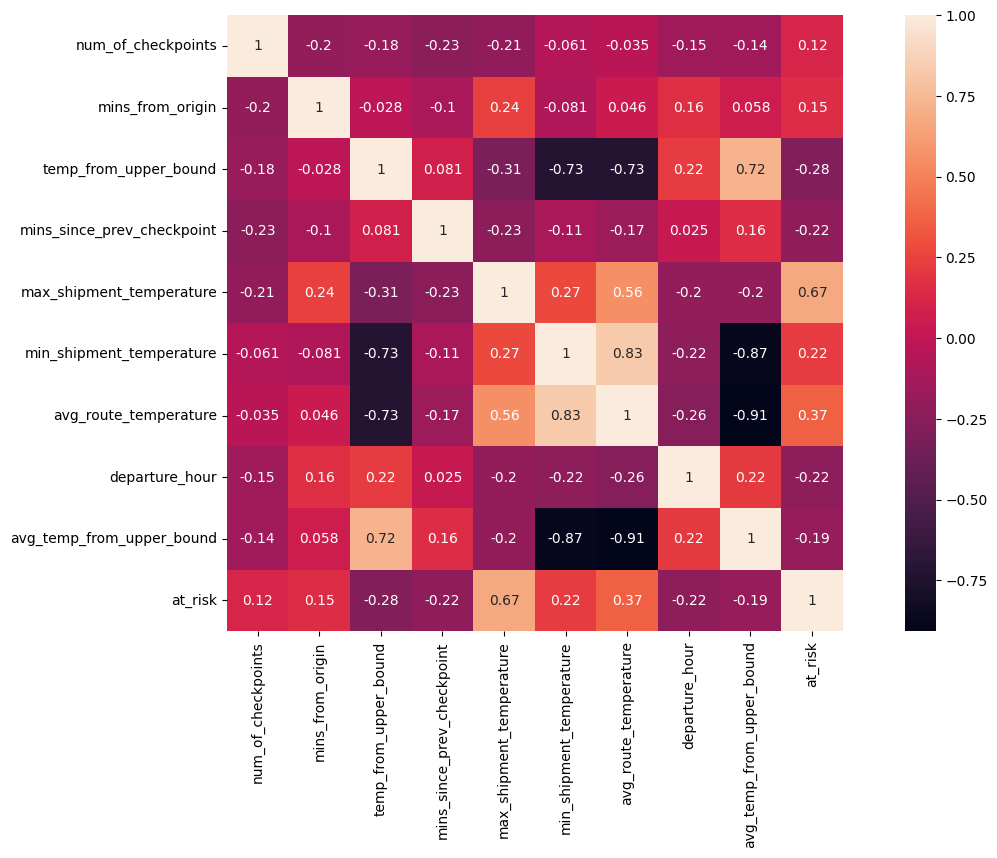

In [4176]:
# plot the heatmap for the remaining variables to double check correlations

fig , ax = plt.subplots(figsize = (16,8))
sns.heatmap(model_data.corr(method = 'pearson', numeric_only = True), square = True, annot = True)


In [4177]:
# alias data, split the response and the feature set

feature_set = model_data.iloc[:,1:-1]
response_var = pd.factorize(model_data.iloc[:,-1])[0].reshape(-1,1)

#split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    feature_set, response_var, random_state = 127, test_size = .25)



In [4178]:
# function that will produce thee outputs of a grid search for the xgboost model

def grid_search_models(model_name, x_train_df, y_train_df, num_estimators_per_param, random_state): 
    if str(model_name).lower() in ("xg boost", "xgboost", "xg_boost"):
        grid = {'n_estimators': [n for n in range(50,300,25)[0: num_estimators_per_param]],
              'min_child_weight': [n for n in range(2,20,1)[0: num_estimators_per_param]],
              'max_depth': [n for n in range(2,20,1)[0: num_estimators_per_param]]}
        xgb_grid_search = GridSearchCV(XGBClassifier(random_state = random_state), param_grid = grid,
                          cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = random_state), scoring = 'f1')
        xgb_grid_search.fit(x_train_df, y_train_df)
        print(xgb_grid_search.best_params_)
        return(xgb_grid_search.best_params_)
    

In [4179]:
# function that runs logistic regression and xgboost model and produces their model evaluation metrics 

def build_and_evaluate(model_name, x_train_data, y_train_data, x_test_data, y_test_data, random_state, num_estimators_per_param):
   
    if str(model_name).lower() in ("logistic","logistic_regression"):
        classifier = LogisticRegression(max_iter = 100, 
                                        random_state = random_state, 
                                        penalty = "l1", 
                                        solver='liblinear', 
                                        C = .02)
    if str(model_name).lower() in ("xg boost", "xgboost", "xg_boost"):
        xgb_params = grid_search_models(model_name, x_train_data, 
                                        y_train_data, 
                                        num_estimators_per_param, 
                                        random_state)
        classifier = XGBClassifier(n_estimators = xgb_params['n_estimators'], 
                                   min_child_weight = xgb_params['min_child_weight'], 
                                   max_depth = xgb_params['max_depth'], 
                                   booster = "gblinear", 
                                   reg_alpha = .02)
    
    #fit the classifier to the training data
    classifier.fit(x_train_data, y_train_data)
    
    #predict using the test data on the logistic model
    model_predictions = classifier.predict(x_test_data)
    model_prediction_probs = classifier.predict_proba(x_test_data)
    model_prediction_probs = model_prediction_probs[:][: ,1]

    y_test_copy = pd.DataFrame(y_test_data.copy())
    y_test_copy.reset_index(drop = True, inplace = True)
    y_test_copy = pd.concat([y_test_copy,  pd.DataFrame(model_prediction_probs)], axis = 1)
    y_test_copy.columns = ['actuals', 'probs']

    y_test_copy.index = x_test_data.index
    
    # evaluation metrics
    model_accuracy = accuracy_score(y_test_data, model_predictions)
    class_score = classification_report(y_test_data, model_predictions)
    roc = roc_auc_score(y_test_data, model_predictions)
    print(model_name + " Model Accuracy: " + str(model_accuracy))
    print(model_name + " Classification Report: \n")
    print(class_score)
    print(model_name + "AUC: " + str(roc))
    print(" ")

    #plot roc curve
    false_pos, true_pos,_= roc_curve(y_test_copy['actuals'], y_test_copy['probs'])

    plt.plot(false_pos, true_pos)
    plt.title('ROC Curve')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    # confusion matrix
    c_matrix = confusion_matrix(y_test_data, model_predictions)
    print(c_matrix)
    #sns.heatmap(c_matrix/np.sum(c_matrix), annot = True, cmap = 'Blues')

    #retrieve model coefficients for future scorecard

    coef_df = pd.DataFrame(columns = ['feature'], data = x_train_data.columns.values)
    coef_df['coefficients'] = np.transpose(classifier.coef_)
    coef_df.index = coef_df.index + 1
    coef_df.loc[0] = ["model_intercept", classifier.intercept_[0]]
    coef_df.sort_index(inplace = True)
    return(coef_df)



logistic_regression Model Accuracy: 0.6363636363636364
logistic_regression Classification Report: 

              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11

logistic_regressionAUC: 0.5
 
[[7 0]
 [4 0]]


,feature,coefficients
0,model_intercept,0.0000000000
1,mins_from_origin,-0.0007462984
2,temp_from_upper_bound,0.0000000000
3,mins_since_prev_checkpoint,0.0000000000
4,max_shipment_temperature,0.0000000000
5,min_shipment_temperature,0.0000000000
6,avg_route_temperature,0.0000000000
7,departure_hour,0.0000000000
8,avg_temp_from_upper_bound,0.0000000000


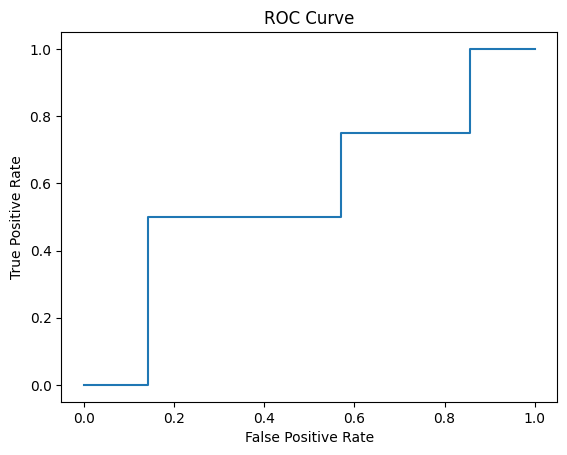

In [4180]:
# build and evaluate logistic regression model

logit_model = build_and_evaluate("logistic_regression", x_train, y_train, x_test, y_test, 227, 2)
logit_model       

{'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 50}
xg_boost Model Accuracy: 0.8181818181818182
xg_boost Classification Report: 

              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.67      1.00      0.80         4

    accuracy                           0.82        11
   macro avg       0.83      0.86      0.82        11
weighted avg       0.88      0.82      0.82        11

xg_boostAUC: 0.8571428571428572
 
[[5 2]
 [0 4]]


,feature,coefficients
0,model_intercept,1.6099400000
1,mins_from_origin,-0.0005834060
2,temp_from_upper_bound,0.3927390000
3,mins_since_prev_checkpoint,0.0081206800
4,max_shipment_temperature,-0.6114770000
5,min_shipment_temperature,0.0380042000
6,avg_route_temperature,0.0344145000
7,departure_hour,0.1261750000
8,avg_temp_from_upper_bound,0.3097440000


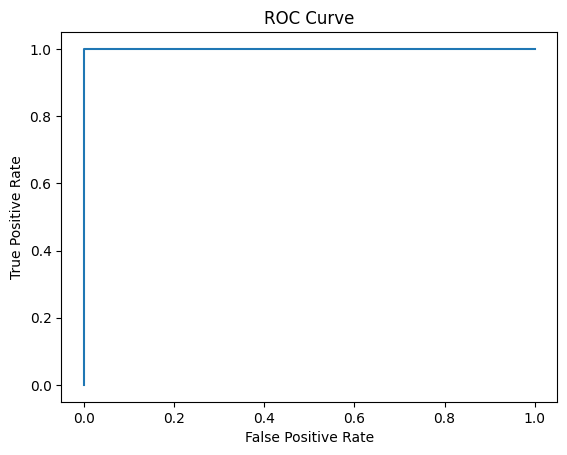

In [4181]:
# build and evaluate the xgboost model

xgb_model = build_and_evaluate("xg_boost", x_train, y_train, x_test, y_test, 227, 2)
xgb_model


### Scorecard Development

In [4184]:
# the scorecard will be based on the coefficients of the XGboost Model

xgb_model_coefs = xgb_model.copy() 
xgb_model_coefs = xgb_model_coefs[xgb_model_coefs['coefficients'] != 0]
xgb_model_coefs



,feature,coefficients
0,model_intercept,1.6099400000
1,mins_from_origin,-0.0005834060
2,temp_from_upper_bound,0.3927390000
3,mins_since_prev_checkpoint,0.0081206800
4,max_shipment_temperature,-0.6114770000
5,min_shipment_temperature,0.0380042000
6,avg_route_temperature,0.0344145000
7,departure_hour,0.1261750000
8,avg_temp_from_upper_bound,0.3097440000


In [4185]:
# limit the feature_set only to the variables that were shown to be significant in the logistic regression model
list(xgb_model_coefs['feature'])


['model_intercept',
 'mins_from_origin',
 'temp_from_upper_bound',
 'mins_since_prev_checkpoint',
 'max_shipment_temperature',
 'min_shipment_temperature',
 'avg_route_temperature',
 'departure_hour',
 'avg_temp_from_upper_bound']

In [4186]:
# subset for the final feature set and create a min_max binning of the variables
# assign the estimator and the same hyperparameters that were tuned for the original model to the estimator

final_feature_set = feature_set[[
'mins_from_origin',
 'temp_from_upper_bound',
 'mins_since_prev_checkpoint',
 'max_shipment_temperature',
 'min_shipment_temperature',
 'avg_route_temperature',
 'departure_hour',
 'avg_temp_from_upper_bound']]

variable_bins = BinningProcess(final_feature_set.columns.values,
                              selection_criteria = {
                                  "iv":{"min":.04, "max":1},
                                  "quality_score":{"min":.02}
                              })

classifier = XGBClassifier(n_estimators = 50, min_child_weight = 2, 
                                   max_depth = 2, booster = "gblinear", reg_alpha = .02)


In [4187]:
# perform a min max scaling on 100 scale on the bins of the final variable selection

risk_scorecard = Scorecard(binning_process = variable_bins, estimator = classifier, scaling_method = "min_max",
                          scaling_method_params = {"min":0, "max":100}, intercept_based = True)

In [4188]:
# fit the scorecard on the 0 to 100 scale to the data and print the summary

response_var_score = pd.factorize(model_data.iloc[:,-1])[0]

risk_scorecard.fit(final_feature_set, response_var_score)
risk_scorecard.table(style = "summary").groupby(["Variable"]).agg({"Points":[np.min, np.max]}).sum()
risk_scorecard.table(style = "summary")


,Variable,Bin,Points
0,mins_from_origin,"(-inf, 9.95)",23.6722593292
1,mins_from_origin,"[9.95, 119.62)",11.5664648861
2,mins_from_origin,"[119.62, 141.59)",0.0000000000
3,mins_from_origin,"[141.59, 204.65)",19.8714787331
4,mins_from_origin,"[204.65, inf)",41.9876192793
5,mins_from_origin,Special,18.1403674649
6,mins_from_origin,Missing,18.1403674649
0,min_shipment_temperature,"(-inf, 4.55)",10.9277137982
1,min_shipment_temperature,"[4.55, 4.75)",0.0000000000
2,min_shipment_temperature,"[4.75, 5.15)",15.2855939784


In [4196]:
# score the testing data and print the quantiles

print(risk_scorecard.score(x_test))
np.quantile(risk_scorecard.score(x_test), [0,.2,.4,.6,.8,1])

[33.69099532 49.41104602 64.43491168 34.12545204 53.35817968 47.72190138
 57.38471693 45.05316584 85.25192932 26.71041519 53.35817968]


array([26.71041519, 34.12545204, 47.72190138, 53.35817968, 57.38471693,
       85.25192932])

In [ ]:
#